### Explore stroke dataset

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import sys, os
import glob
import nibabel as nib
import cv2
import torch
from tqdm import tqdm
import segmentation_models_pytorch as smp
import random
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split, KFold
import torch.nn.functional as F
from monai.utils import first, set_determinism
from monai.transforms import (
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Resized,
    Resize,
 RandAffined,
 ToTensord,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate



In [2]:
data_dir = r"D:\research\Dataset\stroke dataset\ISLES-2022\ISLES-2022"

In [3]:
seg_sample = os.path.join(data_dir, "derivatives", "sub-strokecase0001", "ses-0001", "sub-strokecase0001_ses-0001_msk.nii.gz")
dwi_sample = os.path.join(data_dir, "sub-strokecase0001", "ses-0001", "dwi", "sub-strokecase0001_ses-0001_dwi.nii.gz")
adc_sample = os.path.join(data_dir, "sub-strokecase0001", "ses-0001", "dwi", "sub-strokecase0001_ses-0001_adc.nii.gz")
flair_sample = os.path.join(data_dir, "sub-strokecase0001", "ses-0001", "anat", "sub-strokecase0001_ses-0001_FLAIR.nii.gz")

In [4]:
seg_sample_img_info = nib.load(seg_sample).get_fdata()
print("mask unit voxel size: ", nib.load(seg_sample).header.get_zooms())

dwi_sample_img_info = nib.load(dwi_sample)
print("dwi unit voxel size: ", dwi_sample_img_info.header.get_zooms())

adc_sample_img_info = nib.load(adc_sample)
print("adc unit voxel size: ", adc_sample_img_info.header.get_zooms())

seg_sample_img_info = nib.load(seg_sample)
print("seg unit voxel size: ", seg_sample_img_info.header.get_zooms())

mask unit voxel size:  (2.0, 2.0, 2.0)
dwi unit voxel size:  (2.0, 2.0, 2.0)
adc unit voxel size:  (2.0, 2.0, 2.0)
seg unit voxel size:  (2.0, 2.0, 2.0)


In [5]:
seg_sample_img = nib.load(seg_sample).get_fdata()
dwi_sample_img = nib.load(dwi_sample).get_fdata()
adc_sample_img = nib.load(adc_sample).get_fdata()
flair_sample_img = nib.load(flair_sample).get_fdata()

In [6]:
print("segmentation label shape: ", seg_sample_img.shape)   
print("dwi shape: ", dwi_sample_img.shape)  
print("adc shape: ", adc_sample_img.shape)
print("flair shape: ", flair_sample_img.shape)


segmentation label shape:  (112, 112, 73)
dwi shape:  (112, 112, 73)
adc shape:  (112, 112, 73)
flair shape:  (281, 352, 352)


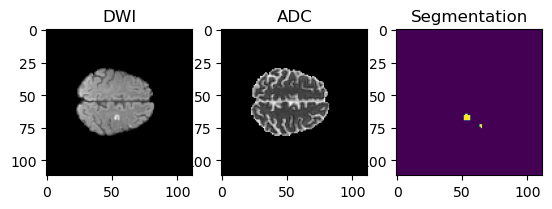

In [7]:
plt.subplot(1, 3, 1)
plt.imshow(dwi_sample_img[:, :, 55], cmap='gray')
plt.title('DWI')

# Second subplot
plt.subplot(1, 3, 2)
plt.imshow(adc_sample_img[:, :, 55], cmap='gray')
plt.title('ADC')

# Third subplot
plt.subplot(1, 3, 3)
plt.imshow(seg_sample_img[:, :, 55])
plt.title('Segmentation')

# Display all subplots
plt.show()


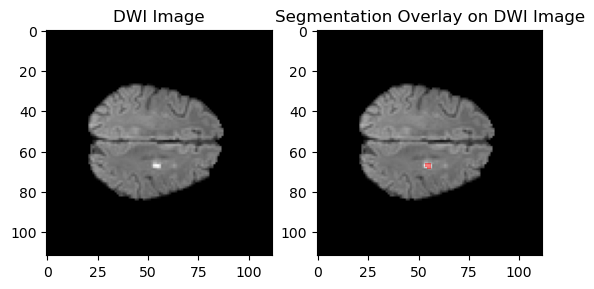

In [8]:
# Plot the DWI image
plt.subplot(1, 2, 1)
plt.imshow(dwi_sample_img[:, :, 50], cmap='gray')
plt.title('DWI Image')

# Plot the segmentation overlay on top of the DWI image
plt.subplot(1, 2, 2)
plt.imshow(dwi_sample_img[:, :, 50], cmap='gray')
mask_ = np.ma.masked_where(seg_sample_img==0, seg_sample_img)
plt.imshow(mask_[:, :, 50], alpha=0.5, cmap='autumn')  # Adjust alpha for transparency
plt.title('Segmentation Overlay on DWI Image')

plt.show()

### Prepare data

In [9]:
all_files = sorted(glob.glob(os.path.join(data_dir, "*sub-strokecase*")))
print("Total files: ", len(all_files))

Total files:  250


In [10]:
all_files[0].split(os.sep)[-1]

'sub-strokecase0001'

In [11]:
def load_data2D(all_files, target_size=(128, 128)):
    """
    load data from all_files and return a list of dictionary
    each dictionary contains image and label
    image contains 3 channels, each channel is a 2D slice from DWI image, sized to target_size
    label contains 1 channel, a 2D slice from segmentation label/mask, sized to target_size
    """
    data_dict = []
    for file in tqdm(all_files, desc="Loading data"):
        filename = file.split(os.sep)[-1]
        dwi_file = glob.glob(os.path.join(file, "ses-0001", "dwi", "*dwi.nii.gz"))[0]
        # adc_file = glob.glob(os.path.join(file, "ses-0001", "dwi", "*adc.nii.gz"))[0]
        seg_file = glob.glob(os.path.join(data_dir, "derivatives", filename, "ses-0001", "*msk.nii.gz"))[0]

        dwi_img = nib.load(dwi_file).get_fdata()
        # adc_img = nib.load(adc_file).get_fdata()
        seg_img = nib.load(seg_file).get_fdata()

        if np.sum(seg_img) == 0:
            continue


        dwi_img = (dwi_img - np.mean(dwi_img)) / np.std(dwi_img)
        # adc_img = (adc_img - np.mean(adc_img)) / np.std(adc_img)
        seg_img[seg_img > 0] = 1

        num_slices = dwi_img.shape[2]
        for j in range(num_slices):
            if np.sum(seg_img[:, :, j]) == 0:
                continue 
            dwi_2d = cv2.resize(dwi_img[:, :, j], dsize=target_size, interpolation=cv2.INTER_LINEAR)
            # adc_2d = cv2.resize(adc_img[:, :, j], dsize=target_size, interpolation=cv2.INTER_LINEAR)
            label_2d = cv2.resize(seg_img[:, :, j], dsize=target_size, interpolation=cv2.INTER_NEAREST)
            
            
            
            # Duplicate the single channel to create a 3-channel image
            image_slice = cv2.merge([dwi_2d, dwi_2d, dwi_2d])

            # move channel dimension as the first dimension
            image = np.moveaxis(image_slice, -1, 0)
            
            # add channel dimension to label
            label = np.expand_dims(label_2d, axis=0)
            
            data_dict.append({"image": image, "label": label})

    return data_dict

In [12]:
# def extract_pos_slice(images, masks):
#     """
#     Extract positive slices from data_dicts.
#     """
#     pos_masks = []
#     pos_images = []
#     for i in range(len(images)):
#         if np.sum(masks[i]) > 0:
#             pos_masks.append(masks[i])
#             pos_images.append(images[i])
#     return pos_images, pos_masks

In [13]:
data_dicts = load_data2D(all_files, target_size=(128, 128))

Loading data: 100%|██████████| 250/250 [00:20<00:00, 11.98it/s]


In [15]:
# images, masks = prepare_data(all_files)

In [14]:
data_dicts[0]["image"].shape, data_dicts[0]["label"].shape

((3, 128, 128), (1, 128, 128))

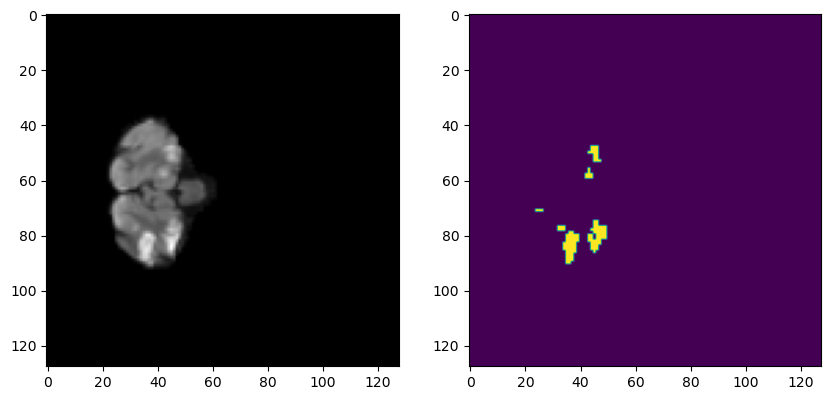

In [15]:
plt.figure(figsize=(10, 10)) 
plt.subplot(1, 2, 1)
plt.imshow(data_dicts[300]["image"][0, :, :], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data_dicts[300]["label"][0, :, :])

plt.show()


In [16]:
np.unique(data_dicts[3000]["label"], return_counts=True)

(array([0., 1.]), array([16381,     3], dtype=int64))

In [17]:
len(np.unique(data_dicts[300]["image"]))

1570

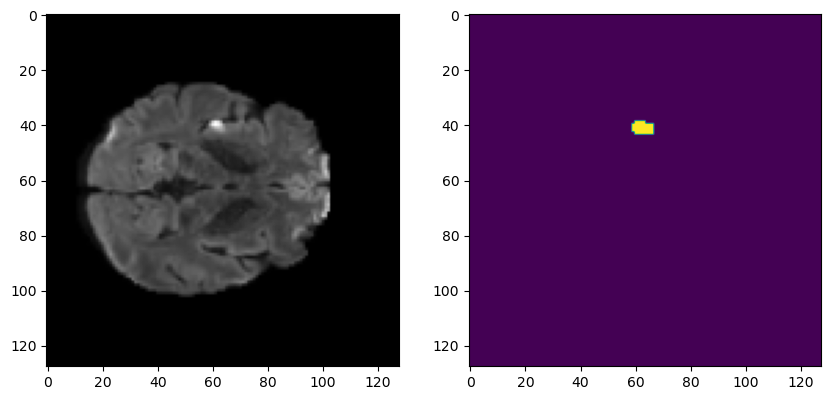

In [18]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(data_dicts[100]["image"][0, :, :], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data_dicts[100]["label"][0, :, :])

plt.show()

In [19]:
# # calculate class weights
# masks_arr = np.array(masks)
# pos_weight_val = np.sum(masks_arr == 0) / np.sum(masks_arr == 1)
# pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32)
# print("pos_weight: ", pos_weight)

In [20]:
# (masks_arr == 1).sum() / (masks_arr == 0).sum()

In [21]:
# pos_data = extract_pos_slice(data_dict)

In [22]:
# data = data_dict + pos_data * 3

In [23]:
# len(data)

In [24]:
data = data_dicts
random.shuffle(data)

In [25]:
# # Split the dataset into training and testing sets
# images_train, images_test, masks_train, masks_test = train_test_split(
#     images, masks, test_size=0.2, random_state=42
# )

In [26]:
data, test_data = data[:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [27]:
len(data), len(test_data)

(3861, 966)

In [28]:
# create 5 folds of cross_validation
from sklearn.model_selection import KFold

# Number of folds for cross-validation
num_CV = 5
kf = KFold(n_splits=num_CV, shuffle=True, random_state=42)

# Lists to store training and validation sets for each fold
train_files, val_files = [], []

# Loop through the folds
for train_index, val_index in kf.split(data):

    train_data, val_data = [data[i] for i in train_index], [data[i] for i in val_index]

    # Append the training and validation sets to the lists
    train_files.append(train_data)
    val_files.append(val_data)

In [29]:
train_transforms = Compose(
    [
            RandAffined(
             keys=['image', 'label'],
             mode=('bilinear', 'nearest'),
             prob=0.2, spatial_size=(128, 128),
             rotate_range=(0, 0, np.pi/15),
             scale_range=(0.1, 0.1, 0.1),
            translate_range=(0.1, 0.1, 0.1),
            padding_mode='border'),
            ToTensord(keys=["image", "label"], dtype=torch.float32),
    ]
)

val_transforms = Compose(
    [
        ToTensord(keys=["image", "label"], dtype=torch.float32),
    ]
)

In [30]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

In [31]:
image_sample, label_sample = (check_data["image"][0][0], check_data["label"][0][0])
torch.sum(label_sample).item()

6.0

torch.Size([773, 3, 128, 128])
image shape: torch.Size([128, 128]), label shape: torch.Size([128, 128])


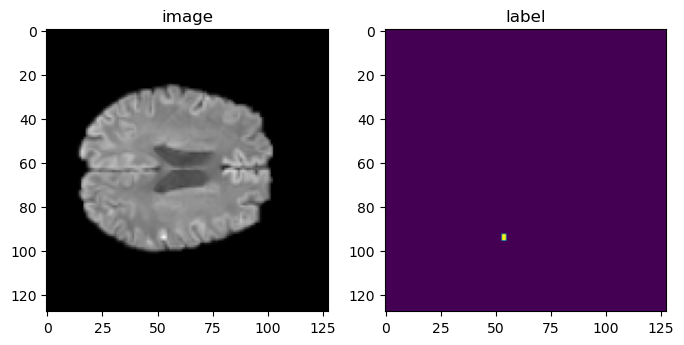

In [32]:

print(check_data["image"].shape)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# unique_values, counts = torch.unique(label, return_counts=True)
# print(unique_values, counts)
# print(sum(counts[1:]))
# plot the slice [:, :, 50]
plt.figure("check", (8,6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :])
plt.show()

### Training

In [55]:
device = torch.device("cuda:0") 
loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
# loss_function2 = smp.losses.FocalLoss(mode="binary", alpha=0.9, gamma=2.0)

# Create the UNet model with the specified backbone
model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,
    classes=1, 
    activation="sigmoid", 
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


In [56]:
root_dir = "output/"

In [57]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []


num_CV = 5
max_epochs = 300
epoch_per_CV = max_epochs // num_CV

for i in range(num_CV):

    print("-" * 10)
    print(f"Fold {i}")
    train_ds = Dataset(data=train_files[i], transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
    val_ds = Dataset(data=val_files[i], transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=4)

    if i < num_CV - 1:
        start_epoch = i * epoch_per_CV
        end_epoch = (i + 1) * epoch_per_CV
    else:
        start_epoch = i * epoch_per_CV
        end_epoch = max_epochs

    for epoch in range(start_epoch, end_epoch):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # Training
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader, desc="Training"):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Validation
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_iou = 0.0
            num_batches = len(val_loader)

            with torch.no_grad():
                for val_data in tqdm(val_loader, desc="Validation"):
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                    val_outputs = model(val_inputs)
                    val_outputs = (val_outputs > 0.5).float()  # Assuming sigmoid activation

                    # Calculate Dice for the batch
                    intersection = torch.sum(val_outputs * val_labels)
                    union = torch.sum(val_outputs) + torch.sum(val_labels) - intersection
                    iou = (intersection + 1e-15) / (union + 1e-15)
                    val_iou += iou.item()

            # Calculate average IoU across all batches
            average_val_iou = val_iou / num_batches
            metric_values.append(average_val_iou)

            if average_val_iou > best_metric:
                best_metric = average_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                f"\nbest mean IoU: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
Fold 0
----------
epoch 1/300


Training: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s]


epoch 1 average loss: 0.8697
----------
epoch 2/300


Training: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


epoch 2 average loss: 0.4226


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saved new best metric model
current epoch: 2 current mean IoU: 0.5999
best mean IoU: 0.5999 at epoch: 2
----------
epoch 3/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


epoch 3 average loss: 0.2459
----------
epoch 4/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


epoch 4 average loss: 0.2132


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


current epoch: 4 current mean IoU: 0.3471
best mean IoU: 0.5999 at epoch: 2
----------
epoch 5/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


epoch 5 average loss: 0.1987
----------
epoch 6/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 6 average loss: 0.1846


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


saved new best metric model
current epoch: 6 current mean IoU: 0.6392
best mean IoU: 0.6392 at epoch: 6
----------
epoch 7/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


epoch 7 average loss: 0.1691
----------
epoch 8/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


epoch 8 average loss: 0.1647


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.77s/it]


saved new best metric model
current epoch: 8 current mean IoU: 0.6769
best mean IoU: 0.6769 at epoch: 8
----------
epoch 9/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 9 average loss: 0.1670
----------
epoch 10/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


epoch 10 average loss: 0.1600


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


saved new best metric model
current epoch: 10 current mean IoU: 0.7025
best mean IoU: 0.7025 at epoch: 10
----------
epoch 11/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 11 average loss: 0.1586
----------
epoch 12/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44it/s]


epoch 12 average loss: 0.1433


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


current epoch: 12 current mean IoU: 0.6917
best mean IoU: 0.7025 at epoch: 10
----------
epoch 13/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


epoch 13 average loss: 0.1418
----------
epoch 14/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 14 average loss: 0.1403


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


current epoch: 14 current mean IoU: 0.6155
best mean IoU: 0.7025 at epoch: 10
----------
epoch 15/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 15 average loss: 0.1318
----------
epoch 16/300


Training: 100%|██████████| 49/49 [00:36<00:00,  1.34it/s]


epoch 16 average loss: 0.1246


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saved new best metric model
current epoch: 16 current mean IoU: 0.7151
best mean IoU: 0.7151 at epoch: 16
----------
epoch 17/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


epoch 17 average loss: 0.1260
----------
epoch 18/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.39it/s]


epoch 18 average loss: 0.1226


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


saved new best metric model
current epoch: 18 current mean IoU: 0.7246
best mean IoU: 0.7246 at epoch: 18
----------
epoch 19/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


epoch 19 average loss: 0.1239
----------
epoch 20/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.40it/s]


epoch 20 average loss: 0.1298


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


saved new best metric model
current epoch: 20 current mean IoU: 0.7348
best mean IoU: 0.7348 at epoch: 20
----------
epoch 21/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.37it/s]


epoch 21 average loss: 0.1246
----------
epoch 22/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


epoch 22 average loss: 0.1336


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


current epoch: 22 current mean IoU: 0.6972
best mean IoU: 0.7348 at epoch: 20
----------
epoch 23/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


epoch 23 average loss: 0.1445
----------
epoch 24/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 24 average loss: 0.1249


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


current epoch: 24 current mean IoU: 0.7068
best mean IoU: 0.7348 at epoch: 20
----------
epoch 25/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 25 average loss: 0.1195
----------
epoch 26/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


epoch 26 average loss: 0.1128


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


saved new best metric model
current epoch: 26 current mean IoU: 0.7396
best mean IoU: 0.7396 at epoch: 26
----------
epoch 27/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


epoch 27 average loss: 0.1151
----------
epoch 28/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


epoch 28 average loss: 0.1113


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


saved new best metric model
current epoch: 28 current mean IoU: 0.7474
best mean IoU: 0.7474 at epoch: 28
----------
epoch 29/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.40it/s]


epoch 29 average loss: 0.1094
----------
epoch 30/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.40it/s]


epoch 30 average loss: 0.1057


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


current epoch: 30 current mean IoU: 0.7425
best mean IoU: 0.7474 at epoch: 28
----------
epoch 31/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 31 average loss: 0.1031
----------
epoch 32/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 32 average loss: 0.0984


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


current epoch: 32 current mean IoU: 0.7453
best mean IoU: 0.7474 at epoch: 28
----------
epoch 33/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 33 average loss: 0.1011
----------
epoch 34/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 34 average loss: 0.1043


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


saved new best metric model
current epoch: 34 current mean IoU: 0.7497
best mean IoU: 0.7497 at epoch: 34
----------
epoch 35/300


Training:   0%|          | 0/49 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001A60EC80F70>
Traceback (most recent call last):
  File "c:\Users\frank\anaconda3\envs\deep_learning\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\frank\anaconda3\envs\deep_learning\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001A60EC80F70>
Traceback (most recent call last):
  File "c:\Users\frank\anaconda3\envs\deep_learning\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\frank\anaconda3\envs\deep_learning\lib\site-packages\torch\utils\data\datal

epoch 35 average loss: 0.1024
----------
epoch 36/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 36 average loss: 0.0981


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


saved new best metric model
current epoch: 36 current mean IoU: 0.7653
best mean IoU: 0.7653 at epoch: 36
----------
epoch 37/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 37 average loss: 0.1009
----------
epoch 38/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 38 average loss: 0.1000


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.79s/it]


current epoch: 38 current mean IoU: 0.7494
best mean IoU: 0.7653 at epoch: 36
----------
epoch 39/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.39it/s]


epoch 39 average loss: 0.0962
----------
epoch 40/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


epoch 40 average loss: 0.0938


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


current epoch: 40 current mean IoU: 0.7648
best mean IoU: 0.7653 at epoch: 36
----------
epoch 41/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


epoch 41 average loss: 0.0909
----------
epoch 42/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


epoch 42 average loss: 0.0893


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


saved new best metric model
current epoch: 42 current mean IoU: 0.7663
best mean IoU: 0.7663 at epoch: 42
----------
epoch 43/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 43 average loss: 0.0928
----------
epoch 44/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 44 average loss: 0.0890


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


saved new best metric model
current epoch: 44 current mean IoU: 0.7741
best mean IoU: 0.7741 at epoch: 44
----------
epoch 45/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


epoch 45 average loss: 0.0918
----------
epoch 46/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.37it/s]


epoch 46 average loss: 0.0974


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.79s/it]


current epoch: 46 current mean IoU: 0.7680
best mean IoU: 0.7741 at epoch: 44
----------
epoch 47/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.39it/s]


epoch 47 average loss: 0.0898
----------
epoch 48/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44it/s]


epoch 48 average loss: 0.0930


Validation: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


current epoch: 48 current mean IoU: 0.7701
best mean IoU: 0.7741 at epoch: 44
----------
epoch 49/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 49 average loss: 0.0872
----------
epoch 50/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 50 average loss: 0.0874


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


current epoch: 50 current mean IoU: 0.7668
best mean IoU: 0.7741 at epoch: 44
----------
epoch 51/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


epoch 51 average loss: 0.0837
----------
epoch 52/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 52 average loss: 0.0850


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


current epoch: 52 current mean IoU: 0.7719
best mean IoU: 0.7741 at epoch: 44
----------
epoch 53/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


epoch 53 average loss: 0.0810
----------
epoch 54/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 54 average loss: 0.0832


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


current epoch: 54 current mean IoU: 0.7497
best mean IoU: 0.7741 at epoch: 44
----------
epoch 55/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


epoch 55 average loss: 0.0861
----------
epoch 56/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


epoch 56 average loss: 0.0804


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


saved new best metric model
current epoch: 56 current mean IoU: 0.7757
best mean IoU: 0.7757 at epoch: 56
----------
epoch 57/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 57 average loss: 0.0822
----------
epoch 58/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 58 average loss: 0.0792


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 58 current mean IoU: 0.7739
best mean IoU: 0.7757 at epoch: 56
----------
epoch 59/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


epoch 59 average loss: 0.0801
----------
epoch 60/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


epoch 60 average loss: 0.0806


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


current epoch: 60 current mean IoU: 0.7710
best mean IoU: 0.7757 at epoch: 56
----------
Fold 1
----------
epoch 61/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44it/s]


epoch 61 average loss: 0.0901
----------
epoch 62/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s]


epoch 62 average loss: 0.0899


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


saved new best metric model
current epoch: 62 current mean IoU: 0.8127
best mean IoU: 0.8127 at epoch: 62
----------
epoch 63/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 63 average loss: 0.1029
----------
epoch 64/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 64 average loss: 0.0942


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saved new best metric model
current epoch: 64 current mean IoU: 0.8142
best mean IoU: 0.8142 at epoch: 64
----------
epoch 65/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 65 average loss: 0.0881
----------
epoch 66/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 66 average loss: 0.0853


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


saved new best metric model
current epoch: 66 current mean IoU: 0.8185
best mean IoU: 0.8185 at epoch: 66
----------
epoch 67/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


epoch 67 average loss: 0.0869
----------
epoch 68/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 68 average loss: 0.0863


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


saved new best metric model
current epoch: 68 current mean IoU: 0.8265
best mean IoU: 0.8265 at epoch: 68
----------
epoch 69/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


epoch 69 average loss: 0.0794
----------
epoch 70/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44it/s]


epoch 70 average loss: 0.0807


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


current epoch: 70 current mean IoU: 0.8251
best mean IoU: 0.8265 at epoch: 68
----------
epoch 71/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


epoch 71 average loss: 0.0744
----------
epoch 72/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 72 average loss: 0.0744


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


saved new best metric model
current epoch: 72 current mean IoU: 0.8288
best mean IoU: 0.8288 at epoch: 72
----------
epoch 73/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 73 average loss: 0.0723
----------
epoch 74/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 74 average loss: 0.0725


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 74 current mean IoU: 0.8274
best mean IoU: 0.8288 at epoch: 72
----------
epoch 75/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


epoch 75 average loss: 0.0740
----------
epoch 76/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 76 average loss: 0.0799


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 76 current mean IoU: 0.8159
best mean IoU: 0.8288 at epoch: 72
----------
epoch 77/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 77 average loss: 0.0731
----------
epoch 78/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 78 average loss: 0.0707


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 78 current mean IoU: 0.8196
best mean IoU: 0.8288 at epoch: 72
----------
epoch 79/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 79 average loss: 0.0696
----------
epoch 80/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 80 average loss: 0.0699


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 80 current mean IoU: 0.8203
best mean IoU: 0.8288 at epoch: 72
----------
epoch 81/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 81 average loss: 0.0705
----------
epoch 82/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 82 average loss: 0.0688


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 82 current mean IoU: 0.8237
best mean IoU: 0.8288 at epoch: 72
----------
epoch 83/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 83 average loss: 0.0703
----------
epoch 84/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 84 average loss: 0.0694


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 84 current mean IoU: 0.8145
best mean IoU: 0.8288 at epoch: 72
----------
epoch 85/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 85 average loss: 0.0717
----------
epoch 86/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 86 average loss: 0.0701


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 86 current mean IoU: 0.8129
best mean IoU: 0.8288 at epoch: 72
----------
epoch 87/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 87 average loss: 0.0678
----------
epoch 88/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 88 average loss: 0.0680


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 88 current mean IoU: 0.8036
best mean IoU: 0.8288 at epoch: 72
----------
epoch 89/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 89 average loss: 0.0674
----------
epoch 90/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 90 average loss: 0.0685


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 90 current mean IoU: 0.8102
best mean IoU: 0.8288 at epoch: 72
----------
epoch 91/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


epoch 91 average loss: 0.0670
----------
epoch 92/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


epoch 92 average loss: 0.0659


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 92 current mean IoU: 0.8093
best mean IoU: 0.8288 at epoch: 72
----------
epoch 93/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 93 average loss: 0.0721
----------
epoch 94/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 94 average loss: 0.0700


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 94 current mean IoU: 0.8083
best mean IoU: 0.8288 at epoch: 72
----------
epoch 95/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 95 average loss: 0.0989
----------
epoch 96/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 96 average loss: 0.0989


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 96 current mean IoU: 0.7821
best mean IoU: 0.8288 at epoch: 72
----------
epoch 97/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 97 average loss: 0.0776
----------
epoch 98/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 98 average loss: 0.0730


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 98 current mean IoU: 0.7977
best mean IoU: 0.8288 at epoch: 72
----------
epoch 99/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 99 average loss: 0.0706
----------
epoch 100/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 100 average loss: 0.0699


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 100 current mean IoU: 0.7637
best mean IoU: 0.8288 at epoch: 72
----------
epoch 101/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 101 average loss: 0.0671
----------
epoch 102/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 102 average loss: 0.0648


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 102 current mean IoU: 0.8119
best mean IoU: 0.8288 at epoch: 72
----------
epoch 103/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 103 average loss: 0.0712
----------
epoch 104/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 104 average loss: 0.0746


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 104 current mean IoU: 0.7979
best mean IoU: 0.8288 at epoch: 72
----------
epoch 105/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 105 average loss: 0.0707
----------
epoch 106/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 106 average loss: 0.0644


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 106 current mean IoU: 0.8073
best mean IoU: 0.8288 at epoch: 72
----------
epoch 107/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 107 average loss: 0.0619
----------
epoch 108/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 108 average loss: 0.0606


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 108 current mean IoU: 0.8074
best mean IoU: 0.8288 at epoch: 72
----------
epoch 109/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 109 average loss: 0.0601
----------
epoch 110/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 110 average loss: 0.0601


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 110 current mean IoU: 0.8088
best mean IoU: 0.8288 at epoch: 72
----------
epoch 111/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 111 average loss: 0.0617
----------
epoch 112/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 112 average loss: 0.0630


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 112 current mean IoU: 0.8101
best mean IoU: 0.8288 at epoch: 72
----------
epoch 113/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 113 average loss: 0.0599
----------
epoch 114/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 114 average loss: 0.0594


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 114 current mean IoU: 0.7923
best mean IoU: 0.8288 at epoch: 72
----------
epoch 115/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 115 average loss: 0.0608
----------
epoch 116/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 116 average loss: 0.0609


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 116 current mean IoU: 0.7991
best mean IoU: 0.8288 at epoch: 72
----------
epoch 117/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 117 average loss: 0.0588
----------
epoch 118/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 118 average loss: 0.0574


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


current epoch: 118 current mean IoU: 0.8086
best mean IoU: 0.8288 at epoch: 72
----------
epoch 119/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 119 average loss: 0.0566
----------
epoch 120/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 120 average loss: 0.0560


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 120 current mean IoU: 0.8069
best mean IoU: 0.8288 at epoch: 72
----------
Fold 2
----------
epoch 121/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


epoch 121 average loss: 0.0675
----------
epoch 122/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 122 average loss: 0.0681


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


saved new best metric model
current epoch: 122 current mean IoU: 0.9025
best mean IoU: 0.9025 at epoch: 122
----------
epoch 123/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 123 average loss: 0.0669
----------
epoch 124/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 124 average loss: 0.0646


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 124 current mean IoU: 0.8964
best mean IoU: 0.9025 at epoch: 122
----------
epoch 125/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


epoch 125 average loss: 0.0663
----------
epoch 126/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


epoch 126 average loss: 0.0640


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 126 current mean IoU: 0.8930
best mean IoU: 0.9025 at epoch: 122
----------
epoch 127/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 127 average loss: 0.0636
----------
epoch 128/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 128 average loss: 0.0641


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 128 current mean IoU: 0.8928
best mean IoU: 0.9025 at epoch: 122
----------
epoch 129/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 129 average loss: 0.0668
----------
epoch 130/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 130 average loss: 0.0669


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 130 current mean IoU: 0.8822
best mean IoU: 0.9025 at epoch: 122
----------
epoch 131/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 131 average loss: 0.0629
----------
epoch 132/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 132 average loss: 0.0609


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 132 current mean IoU: 0.8846
best mean IoU: 0.9025 at epoch: 122
----------
epoch 133/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 133 average loss: 0.0623
----------
epoch 134/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 134 average loss: 0.0630


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 134 current mean IoU: 0.8849
best mean IoU: 0.9025 at epoch: 122
----------
epoch 135/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 135 average loss: 0.0615
----------
epoch 136/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 136 average loss: 0.0613


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 136 current mean IoU: 0.8803
best mean IoU: 0.9025 at epoch: 122
----------
epoch 137/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 137 average loss: 0.0591
----------
epoch 138/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 138 average loss: 0.0588


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 138 current mean IoU: 0.8817
best mean IoU: 0.9025 at epoch: 122
----------
epoch 139/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


epoch 139 average loss: 0.0573
----------
epoch 140/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 140 average loss: 0.0568


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 140 current mean IoU: 0.8804
best mean IoU: 0.9025 at epoch: 122
----------
epoch 141/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 141 average loss: 0.0575
----------
epoch 142/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 142 average loss: 0.0599


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 142 current mean IoU: 0.8797
best mean IoU: 0.9025 at epoch: 122
----------
epoch 143/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


epoch 143 average loss: 0.0594
----------
epoch 144/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 144 average loss: 0.0578


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 144 current mean IoU: 0.8811
best mean IoU: 0.9025 at epoch: 122
----------
epoch 145/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 145 average loss: 0.0577
----------
epoch 146/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 146 average loss: 0.0611


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 146 current mean IoU: 0.8689
best mean IoU: 0.9025 at epoch: 122
----------
epoch 147/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 147 average loss: 0.0580
----------
epoch 148/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 148 average loss: 0.0620


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 148 current mean IoU: 0.8711
best mean IoU: 0.9025 at epoch: 122
----------
epoch 149/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 149 average loss: 0.0588
----------
epoch 150/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 150 average loss: 0.0569


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 150 current mean IoU: 0.8704
best mean IoU: 0.9025 at epoch: 122
----------
epoch 151/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 151 average loss: 0.0574
----------
epoch 152/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 152 average loss: 0.0576


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 152 current mean IoU: 0.8736
best mean IoU: 0.9025 at epoch: 122
----------
epoch 153/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 153 average loss: 0.0602
----------
epoch 154/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 154 average loss: 0.0622


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 154 current mean IoU: 0.8690
best mean IoU: 0.9025 at epoch: 122
----------
epoch 155/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 155 average loss: 0.0579
----------
epoch 156/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 156 average loss: 0.0555


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 156 current mean IoU: 0.8735
best mean IoU: 0.9025 at epoch: 122
----------
epoch 157/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


epoch 157 average loss: 0.0549
----------
epoch 158/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 158 average loss: 0.0537


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 158 current mean IoU: 0.8705
best mean IoU: 0.9025 at epoch: 122
----------
epoch 159/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 159 average loss: 0.0570
----------
epoch 160/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


epoch 160 average loss: 0.0554


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 160 current mean IoU: 0.8622
best mean IoU: 0.9025 at epoch: 122
----------
epoch 161/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 161 average loss: 0.0535
----------
epoch 162/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 162 average loss: 0.0532


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 162 current mean IoU: 0.8661
best mean IoU: 0.9025 at epoch: 122
----------
epoch 163/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 163 average loss: 0.0548
----------
epoch 164/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 164 average loss: 0.0535


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 164 current mean IoU: 0.8659
best mean IoU: 0.9025 at epoch: 122
----------
epoch 165/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 165 average loss: 0.0534
----------
epoch 166/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 166 average loss: 0.0540


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 166 current mean IoU: 0.8542
best mean IoU: 0.9025 at epoch: 122
----------
epoch 167/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 167 average loss: 0.0556
----------
epoch 168/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 168 average loss: 0.0541


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 168 current mean IoU: 0.8643
best mean IoU: 0.9025 at epoch: 122
----------
epoch 169/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 169 average loss: 0.0541
----------
epoch 170/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 170 average loss: 0.0529


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 170 current mean IoU: 0.8671
best mean IoU: 0.9025 at epoch: 122
----------
epoch 171/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 171 average loss: 0.0525
----------
epoch 172/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


epoch 172 average loss: 0.0537


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


current epoch: 172 current mean IoU: 0.8643
best mean IoU: 0.9025 at epoch: 122
----------
epoch 173/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 173 average loss: 0.0571
----------
epoch 174/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 174 average loss: 0.0522


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 174 current mean IoU: 0.8593
best mean IoU: 0.9025 at epoch: 122
----------
epoch 175/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 175 average loss: 0.0506
----------
epoch 176/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 176 average loss: 0.0514


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 176 current mean IoU: 0.8613
best mean IoU: 0.9025 at epoch: 122
----------
epoch 177/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 177 average loss: 0.0553
----------
epoch 178/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


epoch 178 average loss: 0.0528


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 178 current mean IoU: 0.8502
best mean IoU: 0.9025 at epoch: 122
----------
epoch 179/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 179 average loss: 0.0525
----------
epoch 180/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 180 average loss: 0.0544


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


current epoch: 180 current mean IoU: 0.8551
best mean IoU: 0.9025 at epoch: 122
----------
Fold 3
----------
epoch 181/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


epoch 181 average loss: 0.0596
----------
epoch 182/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


epoch 182 average loss: 0.0595


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


saved new best metric model
current epoch: 182 current mean IoU: 0.9104
best mean IoU: 0.9104 at epoch: 182
----------
epoch 183/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 183 average loss: 0.0632
----------
epoch 184/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


epoch 184 average loss: 0.0604


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 184 current mean IoU: 0.8962
best mean IoU: 0.9104 at epoch: 182
----------
epoch 185/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


epoch 185 average loss: 0.0564
----------
epoch 186/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 186 average loss: 0.0547


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 186 current mean IoU: 0.9098
best mean IoU: 0.9104 at epoch: 182
----------
epoch 187/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 187 average loss: 0.0549
----------
epoch 188/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 188 average loss: 0.0565


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 188 current mean IoU: 0.9024
best mean IoU: 0.9104 at epoch: 182
----------
epoch 189/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 189 average loss: 0.0577
----------
epoch 190/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


epoch 190 average loss: 0.0555


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 190 current mean IoU: 0.8987
best mean IoU: 0.9104 at epoch: 182
----------
epoch 191/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.51it/s]


epoch 191 average loss: 0.0537
----------
epoch 192/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 192 average loss: 0.0524


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 192 current mean IoU: 0.8974
best mean IoU: 0.9104 at epoch: 182
----------
epoch 193/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 193 average loss: 0.0525
----------
epoch 194/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 194 average loss: 0.0508


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 194 current mean IoU: 0.9047
best mean IoU: 0.9104 at epoch: 182
----------
epoch 195/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


epoch 195 average loss: 0.0512
----------
epoch 196/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 196 average loss: 0.0502


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 196 current mean IoU: 0.9036
best mean IoU: 0.9104 at epoch: 182
----------
epoch 197/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 197 average loss: 0.0488
----------
epoch 198/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 198 average loss: 0.0498


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 198 current mean IoU: 0.8973
best mean IoU: 0.9104 at epoch: 182
----------
epoch 199/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 199 average loss: 0.0494
----------
epoch 200/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 200 average loss: 0.0480


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 200 current mean IoU: 0.9002
best mean IoU: 0.9104 at epoch: 182
----------
epoch 201/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 201 average loss: 0.0489
----------
epoch 202/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 202 average loss: 0.0494


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 202 current mean IoU: 0.8990
best mean IoU: 0.9104 at epoch: 182
----------
epoch 203/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 203 average loss: 0.0485
----------
epoch 204/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 204 average loss: 0.0529


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


current epoch: 204 current mean IoU: 0.8865
best mean IoU: 0.9104 at epoch: 182
----------
epoch 205/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 205 average loss: 0.0501
----------
epoch 206/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 206 average loss: 0.0508


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 206 current mean IoU: 0.8940
best mean IoU: 0.9104 at epoch: 182
----------
epoch 207/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 207 average loss: 0.0486
----------
epoch 208/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


epoch 208 average loss: 0.0478


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 208 current mean IoU: 0.8871
best mean IoU: 0.9104 at epoch: 182
----------
epoch 209/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 209 average loss: 0.0516
----------
epoch 210/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 210 average loss: 0.0494


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 210 current mean IoU: 0.8850
best mean IoU: 0.9104 at epoch: 182
----------
epoch 211/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 211 average loss: 0.0500
----------
epoch 212/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


epoch 212 average loss: 0.0514


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


current epoch: 212 current mean IoU: 0.8816
best mean IoU: 0.9104 at epoch: 182
----------
epoch 213/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 213 average loss: 0.0810
----------
epoch 214/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 214 average loss: 0.0673


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 214 current mean IoU: 0.8695
best mean IoU: 0.9104 at epoch: 182
----------
epoch 215/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 215 average loss: 0.0601
----------
epoch 216/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 216 average loss: 0.0527


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 216 current mean IoU: 0.8788
best mean IoU: 0.9104 at epoch: 182
----------
epoch 217/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 217 average loss: 0.0509
----------
epoch 218/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 218 average loss: 0.0561


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 218 current mean IoU: 0.8529
best mean IoU: 0.9104 at epoch: 182
----------
epoch 219/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 219 average loss: 0.0543
----------
epoch 220/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 220 average loss: 0.0502


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


current epoch: 220 current mean IoU: 0.8721
best mean IoU: 0.9104 at epoch: 182
----------
epoch 221/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.58it/s]


epoch 221 average loss: 0.0494
----------
epoch 222/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 222 average loss: 0.0488


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 222 current mean IoU: 0.8783
best mean IoU: 0.9104 at epoch: 182
----------
epoch 223/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 223 average loss: 0.0477
----------
epoch 224/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 224 average loss: 0.0466


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 224 current mean IoU: 0.8790
best mean IoU: 0.9104 at epoch: 182
----------
epoch 225/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 225 average loss: 0.0485
----------
epoch 226/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 226 average loss: 0.0527


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 226 current mean IoU: 0.8748
best mean IoU: 0.9104 at epoch: 182
----------
epoch 227/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 227 average loss: 0.0490
----------
epoch 228/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 228 average loss: 0.0502


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 228 current mean IoU: 0.8751
best mean IoU: 0.9104 at epoch: 182
----------
epoch 229/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 229 average loss: 0.0475
----------
epoch 230/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 230 average loss: 0.0476


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 230 current mean IoU: 0.8771
best mean IoU: 0.9104 at epoch: 182
----------
epoch 231/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 231 average loss: 0.0460
----------
epoch 232/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


epoch 232 average loss: 0.0448


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 232 current mean IoU: 0.8631
best mean IoU: 0.9104 at epoch: 182
----------
epoch 233/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 233 average loss: 0.0455
----------
epoch 234/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 234 average loss: 0.0480


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


current epoch: 234 current mean IoU: 0.8762
best mean IoU: 0.9104 at epoch: 182
----------
epoch 235/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.61it/s]


epoch 235 average loss: 0.0468
----------
epoch 236/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 236 average loss: 0.0463


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 236 current mean IoU: 0.8718
best mean IoU: 0.9104 at epoch: 182
----------
epoch 237/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 237 average loss: 0.0449
----------
epoch 238/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 238 average loss: 0.0439


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 238 current mean IoU: 0.8768
best mean IoU: 0.9104 at epoch: 182
----------
epoch 239/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 239 average loss: 0.0444
----------
epoch 240/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 240 average loss: 0.0431


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


current epoch: 240 current mean IoU: 0.8787
best mean IoU: 0.9104 at epoch: 182
----------
Fold 4
----------
epoch 241/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.59it/s]


epoch 241 average loss: 0.0544
----------
epoch 242/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 242 average loss: 0.0533


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


saved new best metric model
current epoch: 242 current mean IoU: 0.9316
best mean IoU: 0.9316 at epoch: 242
----------
epoch 243/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 243 average loss: 0.0543
----------
epoch 244/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 244 average loss: 0.0515


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 244 current mean IoU: 0.9300
best mean IoU: 0.9316 at epoch: 242
----------
epoch 245/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 245 average loss: 0.0512
----------
epoch 246/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 246 average loss: 0.0566


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 246 current mean IoU: 0.9035
best mean IoU: 0.9316 at epoch: 242
----------
epoch 247/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 247 average loss: 0.0558
----------
epoch 248/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


epoch 248 average loss: 0.0543


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


current epoch: 248 current mean IoU: 0.9130
best mean IoU: 0.9316 at epoch: 242
----------
epoch 249/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 249 average loss: 0.0580
----------
epoch 250/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


epoch 250 average loss: 0.0591


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 250 current mean IoU: 0.9076
best mean IoU: 0.9316 at epoch: 242
----------
epoch 251/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


epoch 251 average loss: 0.0539
----------
epoch 252/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


epoch 252 average loss: 0.0524


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


current epoch: 252 current mean IoU: 0.9127
best mean IoU: 0.9316 at epoch: 242
----------
epoch 253/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 253 average loss: 0.0512
----------
epoch 254/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


epoch 254 average loss: 0.0511


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


current epoch: 254 current mean IoU: 0.9148
best mean IoU: 0.9316 at epoch: 242
----------
epoch 255/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.55it/s]


epoch 255 average loss: 0.0493
----------
epoch 256/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54it/s]


epoch 256 average loss: 0.0472


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


current epoch: 256 current mean IoU: 0.9074
best mean IoU: 0.9316 at epoch: 242
----------
epoch 257/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


epoch 257 average loss: 0.0503
----------
epoch 258/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 258 average loss: 0.0543


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


current epoch: 258 current mean IoU: 0.9101
best mean IoU: 0.9316 at epoch: 242
----------
epoch 259/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 259 average loss: 0.0495
----------
epoch 260/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 260 average loss: 0.0478


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


current epoch: 260 current mean IoU: 0.9041
best mean IoU: 0.9316 at epoch: 242
----------
epoch 261/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 261 average loss: 0.0456
----------
epoch 262/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]


epoch 262 average loss: 0.0452


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


current epoch: 262 current mean IoU: 0.9119
best mean IoU: 0.9316 at epoch: 242
----------
epoch 263/300


Training: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


epoch 263 average loss: 0.0452
----------
epoch 264/300


Training: 100%|██████████| 49/49 [00:31<00:00,  1.56it/s]


epoch 264 average loss: 0.0452


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


current epoch: 264 current mean IoU: 0.9048
best mean IoU: 0.9316 at epoch: 242
----------
epoch 265/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 265 average loss: 0.0462
----------
epoch 266/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


epoch 266 average loss: 0.0474


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 266 current mean IoU: 0.9057
best mean IoU: 0.9316 at epoch: 242
----------
epoch 267/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


epoch 267 average loss: 0.0457
----------
epoch 268/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


epoch 268 average loss: 0.0455


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 268 current mean IoU: 0.9052
best mean IoU: 0.9316 at epoch: 242
----------
epoch 269/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


epoch 269 average loss: 0.0456
----------
epoch 270/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 270 average loss: 0.0450


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


current epoch: 270 current mean IoU: 0.9054
best mean IoU: 0.9316 at epoch: 242
----------
epoch 271/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


epoch 271 average loss: 0.0464
----------
epoch 272/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.40it/s]


epoch 272 average loss: 0.0459


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]


current epoch: 272 current mean IoU: 0.8998
best mean IoU: 0.9316 at epoch: 242
----------
epoch 273/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 273 average loss: 0.0469
----------
epoch 274/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


epoch 274 average loss: 0.0447


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


current epoch: 274 current mean IoU: 0.8967
best mean IoU: 0.9316 at epoch: 242
----------
epoch 275/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 275 average loss: 0.0459
----------
epoch 276/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.40it/s]


epoch 276 average loss: 0.0454


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


current epoch: 276 current mean IoU: 0.8996
best mean IoU: 0.9316 at epoch: 242
----------
epoch 277/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 277 average loss: 0.0443
----------
epoch 278/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


epoch 278 average loss: 0.0431


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


current epoch: 278 current mean IoU: 0.9015
best mean IoU: 0.9316 at epoch: 242
----------
epoch 279/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


epoch 279 average loss: 0.0431
----------
epoch 280/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.44it/s]


epoch 280 average loss: 0.0440


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


current epoch: 280 current mean IoU: 0.8985
best mean IoU: 0.9316 at epoch: 242
----------
epoch 281/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44it/s]


epoch 281 average loss: 0.0440
----------
epoch 282/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 282 average loss: 0.0455


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


current epoch: 282 current mean IoU: 0.8934
best mean IoU: 0.9316 at epoch: 242
----------
epoch 283/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 283 average loss: 0.0449
----------
epoch 284/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44it/s]


epoch 284 average loss: 0.0528


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


current epoch: 284 current mean IoU: 0.8883
best mean IoU: 0.9316 at epoch: 242
----------
epoch 285/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.52it/s]


epoch 285 average loss: 0.0480
----------
epoch 286/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


epoch 286 average loss: 0.0481


Validation: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


current epoch: 286 current mean IoU: 0.8861
best mean IoU: 0.9316 at epoch: 242
----------
epoch 287/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


epoch 287 average loss: 0.0478
----------
epoch 288/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44it/s]


epoch 288 average loss: 0.0483


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


current epoch: 288 current mean IoU: 0.8875
best mean IoU: 0.9316 at epoch: 242
----------
epoch 289/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.39it/s]


epoch 289 average loss: 0.0459
----------
epoch 290/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.42it/s]


epoch 290 average loss: 0.0448


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


current epoch: 290 current mean IoU: 0.8871
best mean IoU: 0.9316 at epoch: 242
----------
epoch 291/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


epoch 291 average loss: 0.0443
----------
epoch 292/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


epoch 292 average loss: 0.0442


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


current epoch: 292 current mean IoU: 0.8891
best mean IoU: 0.9316 at epoch: 242
----------
epoch 293/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.48it/s]


epoch 293 average loss: 0.0424
----------
epoch 294/300


Training: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


epoch 294 average loss: 0.0443


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


current epoch: 294 current mean IoU: 0.8912
best mean IoU: 0.9316 at epoch: 242
----------
epoch 295/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


epoch 295 average loss: 0.0427
----------
epoch 296/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.44it/s]


epoch 296 average loss: 0.0427


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


current epoch: 296 current mean IoU: 0.8842
best mean IoU: 0.9316 at epoch: 242
----------
epoch 297/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


epoch 297 average loss: 0.0428
----------
epoch 298/300


Training: 100%|██████████| 49/49 [00:33<00:00,  1.47it/s]


epoch 298 average loss: 0.0443


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]


current epoch: 298 current mean IoU: 0.8863
best mean IoU: 0.9316 at epoch: 242
----------
epoch 299/300


Training: 100%|██████████| 49/49 [00:35<00:00,  1.40it/s]


epoch 299 average loss: 0.0435
----------
epoch 300/300


Training: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]


epoch 300 average loss: 0.0447


Validation: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it]

current epoch: 300 current mean IoU: 0.8771
best mean IoU: 0.9316 at epoch: 242


In [60]:
best_metric, best_metric_epoch

(0.9315929825489337, 242)

In [ ]:
# # plot Iou and loss curve 
# plt.subplot(1 , 2, 1)
# plt.title("loss curve")
# plt.plot()
# plt.xlabel("epoch")


In [61]:
test_ds = Dataset(data=test_data, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=4)


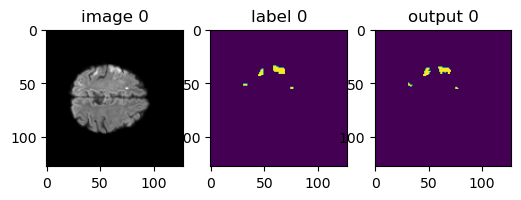

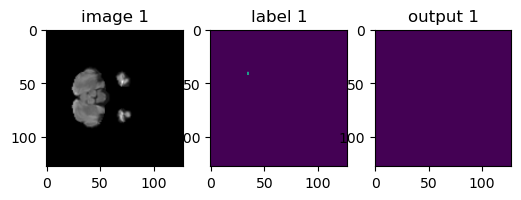

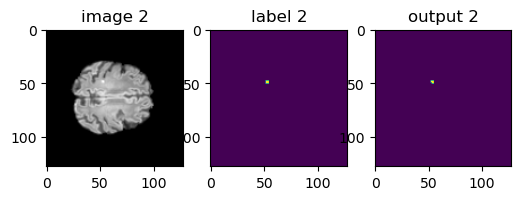

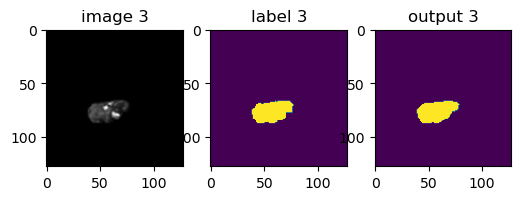

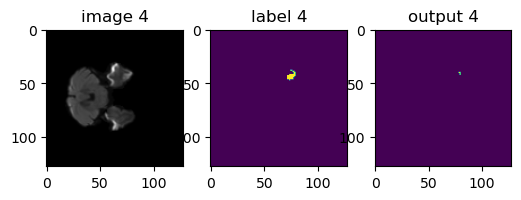

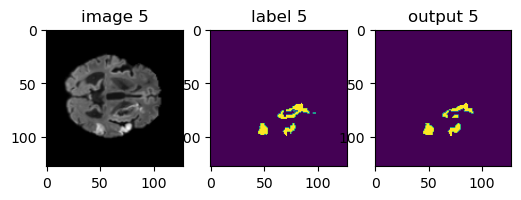

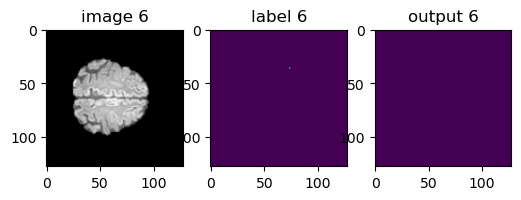

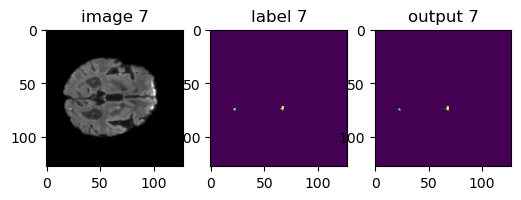

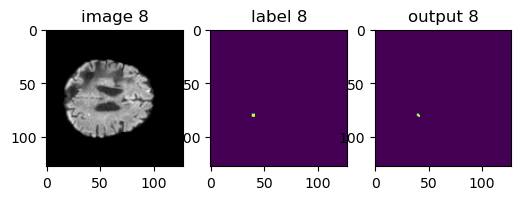

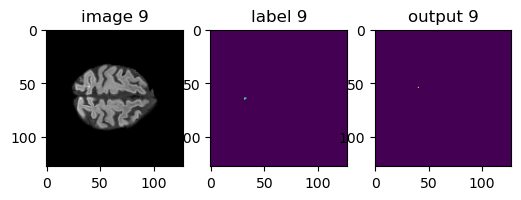

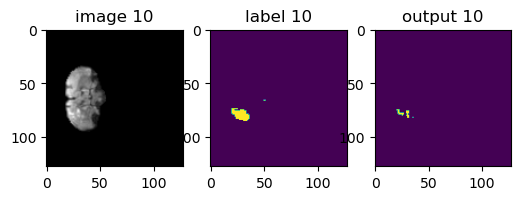

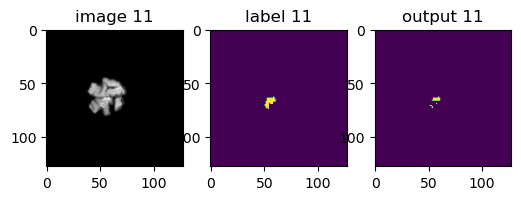

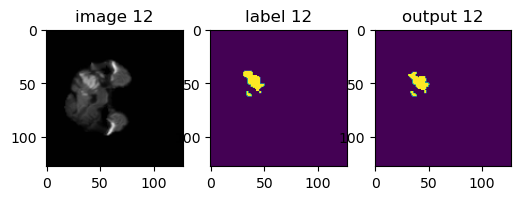

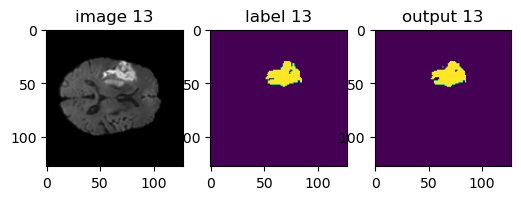

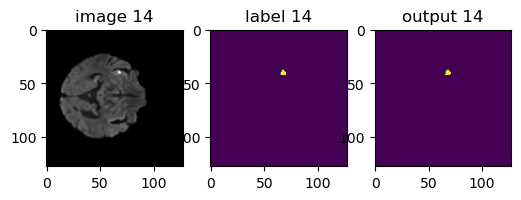

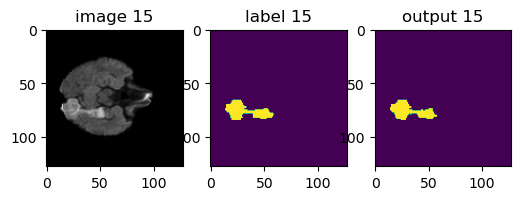

In [62]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        # roi_size = (64, 64, 64)
        # roi_size = (128, 128)
        # sw_batch_size = 4
        val_outputs = model(val_data["image"].to(device))

        val_outputs = (val_outputs > 0.5).float()

        # for j in range(10):
        if i >= 0 and i < 30:
            plt.figure("check", (6, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(val_data["image"][5, 0, :, :], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(val_data["label"][5, 0, :, :])
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            plt.imshow(val_outputs.detach().cpu()[5, 0, :, :])
            plt.show()


        # if i == 41:
        #     break

In [508]:
model.eval()
val_iou = []
count = 0
with torch.no_grad():
    for i in range(len(masks_val[1])):
        # get the image and label
        if np.sum(masks_test[i]) == 0:
            continue
        image, label = images_val[1][i], masks_val[1][i]
        # # add batch dimension on axis 0
        image = np.expand_dims(image, axis=0)
        label = np.expand_dims(label, axis=0)
        
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
    

        count += 1
        # print(image.shape)
        # print("label shape: ", label.shape)
        # # get the prediction
        pred = model(image.to(device))
        # print("pred shape: ", pred.shape)
        # get the prediction mask
        pred_mask = (pred > 0.5).float().detach().cpu()
        # print(pred_mask.shape)
        
        # dice metric
        # Calculate IoU for the batch
        intersection = torch.sum(pred_mask * label)
        union = torch.sum(label) + torch.sum(pred_mask) - intersection
        iou = (intersection + 1e-15) / (union + 1e-15)
        val_iou.append(iou.item())
        # print(f"current IoU: {np.mean(val_iou):.4f}")
        # print(val_iou)
        # break
    # # Calculate average IoU across all batches
    # average_val_iou = val_iou / len(pos_data)
    # print(average_val_iou)

        
        
        # # show images and labels
        # plt.figure("check", (18, 6))
        # plt.subplot(1, 3, 1)
        # plt.title(f"image {i}")
        # plt.imshow(image[0, 0, :, :], cmap="gray")
        # plt.subplot(1, 3, 2)
        # plt.title(f"label {i}")
        # plt.imshow(label[0, 0, :, :])
        # plt.subplot(1, 3, 3)
        # plt.title(f"output {i}")
        # plt.imshow(pred_mask.detach().cpu()[0, 0, :, :])
        # plt.show()
        
        # if count > 10:
        #     break